# Advanced Time Series Visualization in Python: Decomposition of Seasonality, Trend and Autocorrelation
## Analyze seasonality, trend and learn about cool plots like ClusterMaps
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@bentonphotocinema?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Jordan Benton</a>
        on 
        <a href='https://www.pexels.com/photo/shallow-focus-photography-of-hourglass-1095602/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

## Setup

In [58]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

plt.style.use("ggplot")
rcParams["figure.figsize"] = [12, 9]
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15

warnings.filterwarnings("ignore")

## Introduction

Following my [very well-received post](https://towardsdatascience.com/every-pandas-function-you-can-should-use-to-manipulate-time-series-711cb0c5c749?source=your_stories_page-------------------------------------) and [Kaggle notebook](https://www.kaggle.com/bextuychiev/every-pandas-function-to-manipulate-time-series/comments) on every single Pandas function to manipulate time series, it is time to take the trajectory of this TS project to visualization.

This post isn't about how you should plot the date on the XAxis and the time series on YAxis. No.

It is about the core processes that make up a professional time series analyses. Specifically, we will talk about: 
- Decomposition of time series - seasonality and trend analysis
- Calculating autocorrelation and partial autocorrelation and what they represent
- Analyzing and comparing multiple time series simultaneously

and if seasonality or trends among multiple series affect each other. Most importantly, we will build some very cool visualizations and the display image should be a preview of what you will be learning.

I hope you are as excited as I was when writing this post.

## 1. Decomposition of Time Series 

Any time series distribution has 3 core components:

1. **Seasonality** - does the data have a clear cyclical/periodic pattern?
2. **Trend** - does the data represent a general upward or downward slope?
3. **Noise** - what are the outliers or missing values that are not consistent with the rest of the data?

Deconstructing a time series into these components are called decomposition and we will explore each one in detail.

### 1.1 Seasonality analysis

Consider this TPS July Kaggle playground dataset:

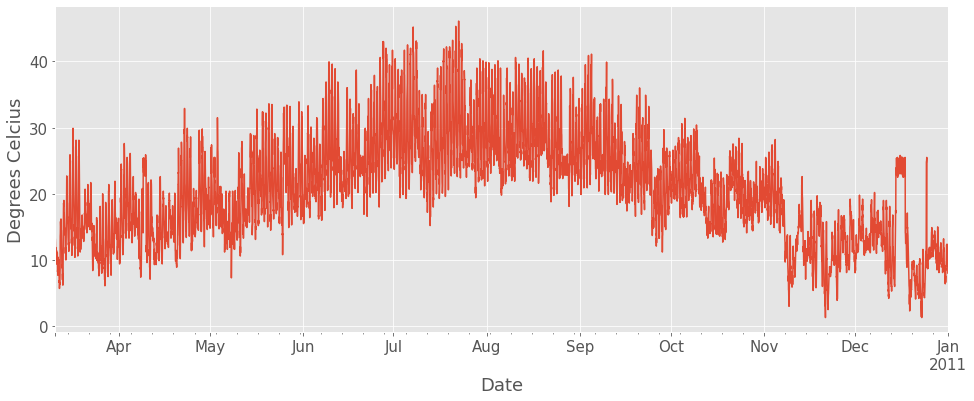

In [59]:
tps = pd.read_csv(
    "data/tps_july_train.csv", parse_dates=["date_time"], index_col="date_time"
)

tps["deg_C"].plot(figsize=(16, 6), fontsize=15)
plt.xlabel("Date")
plt.ylabel("Degrees Celcius");

It is obvious that summer months have higher temperatures and we would expect this behavior to repeat every year. However, the human eye and its ability to detect patterns can only go so far. 

For example, it might be harder to find seasonal patterns from plots such as these:

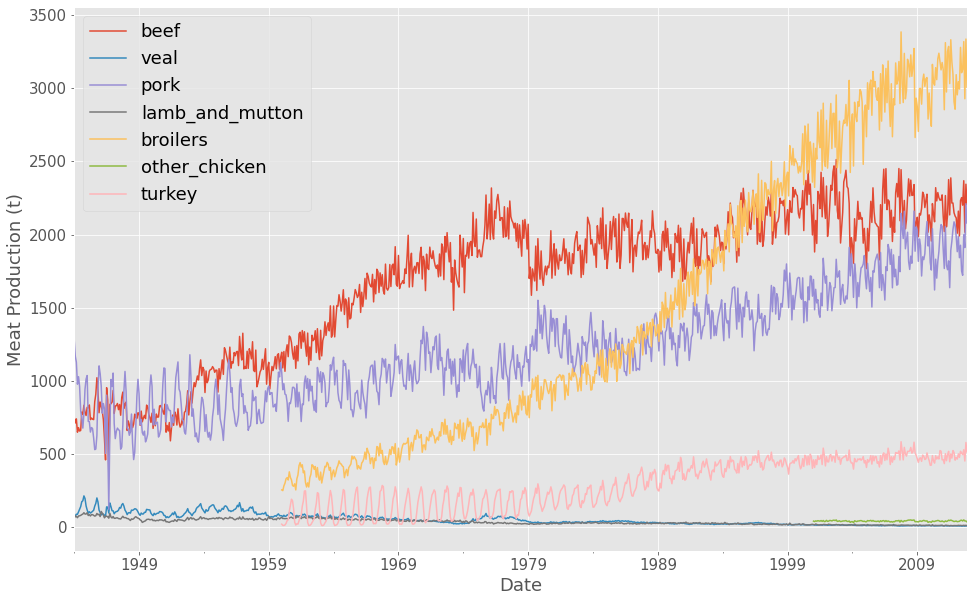

In [60]:
# Load meat production dataset in the USA
meat = pd.read_csv("data/meat_production.csv", parse_dates=["date"], index_col="date")

meat.plot(figsize=(16, 10))
plt.legend(fontsize="large")
plt.xlabel("Date")
plt.ylabel("Meat Production (t)");

To find hidden seasonal patterns from time series like above, we will use the `seasonal_decompose` function from `statsmodels`:

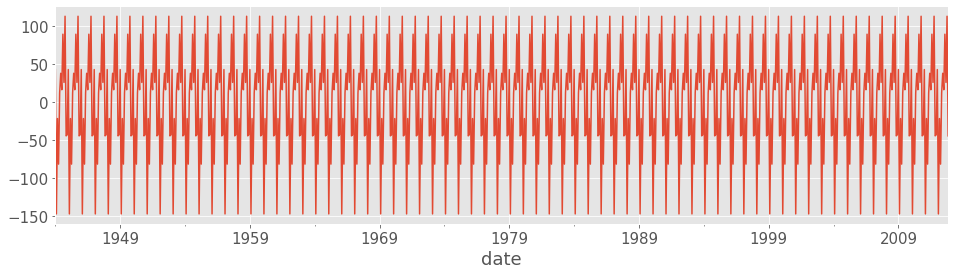

In [61]:
import statsmodels.api as sm
from matplotlib import rcParams

decomposition = sm.tsa.seasonal_decompose(meat["beef"])

rcParams["figure.figsize"] = 16, 4
decomposition.seasonal.plot();

Using `sm.tsa.seasonal_decompose` on 'beef' time series returns a `DecomposeResult` object with attrbiutes like `seasonal`, `trend` and `resid` (more on the last two later). 

Above, we are plotting the seasonality but the plot is not useful since it has too much noise. Let's choose an interval to give the line some room to breathe:

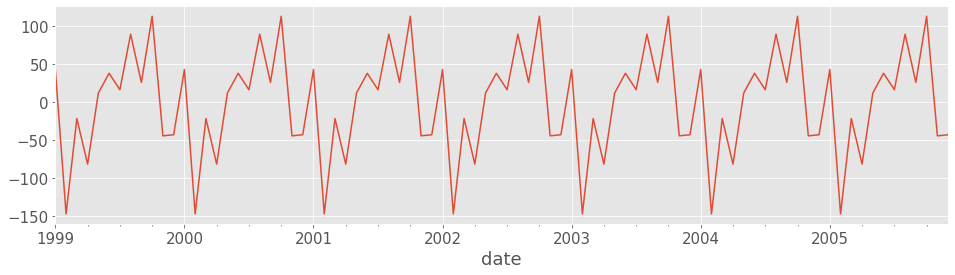

In [62]:
decomposition.seasonal["1999":"2005"].plot();

This plot shows that beef production really goes down at the beginning of each year but towards the end, it reaches its peak.

> Note on `seasonal_decompose` function: it produces small figures by default. You have to control its aspects on your own and the `plot` function does not accept most of the regular Matplotlib parameters.

Now, let's plot the seasonality of all types of meat over a 10 year interval:

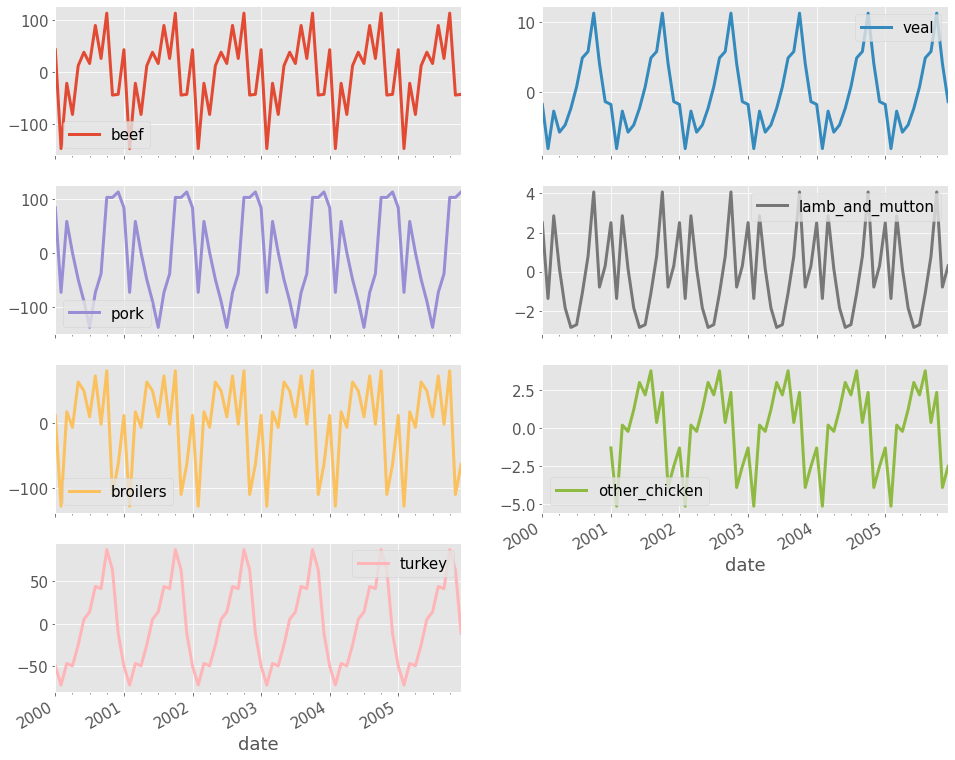

In [63]:
# Init empty dict to store decompose results
seasonality_dict = {}

for ts in meat.columns:
    decompositions = sm.tsa.seasonal_decompose(meat[ts].dropna())
    # Store the results back
    seasonality_dict[ts] = decompositions.seasonal

# Plot
rcParams["figure.figsize"] = 16, 14
pd.DataFrame(seasonality_dict)["2000":"2005"].plot(
    subplots=True, layout=(4, 2), linewidth=3
);

As can be seen, each meat types have rather different seasonality patterns. Now, let's explore trend.

### 1.2 Trend Analysis

Once again, overall trend of a time series shows whether it increased, decreased or stayed constant (flat) over a time period. The above `DecomposeResult` object contains values that show the overall slope of a time series under the `trend` attribute.

Let's plot them for the meat production dataset:

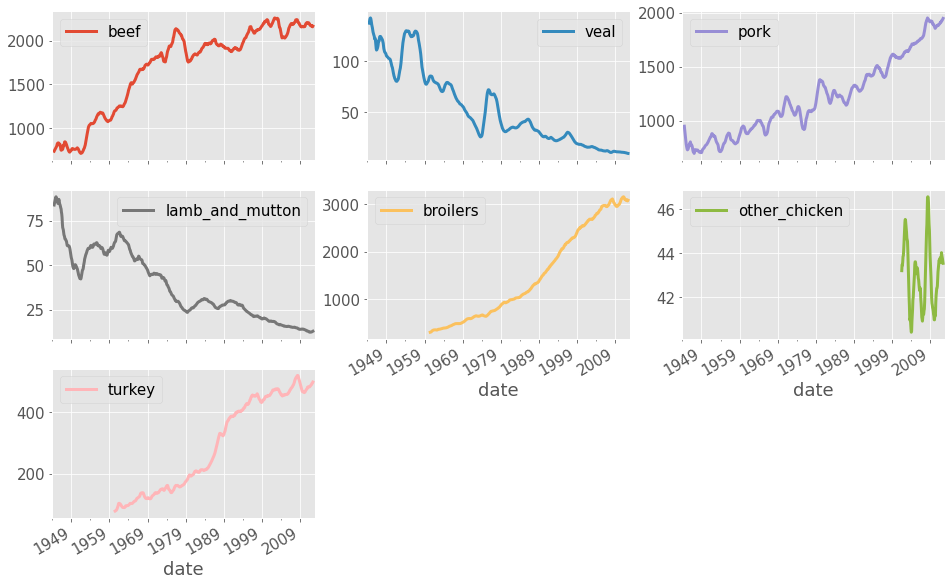

In [67]:
trend_dict = {}

for ts in meat.columns:
    decomposition = sm.tsa.seasonal_decompose(meat[ts].dropna())
    # Store back the results
    trend_dict[ts] = decomposition.trend

pd.DataFrame(trend_dict).plot(subplots=True, layout=(4, 3), linewidth=3);

This plot is massively insightful compared to the simple line plot we saw in the beginning. Indeed, we now see that meat from lambs and veal production decreased dramatically since the 1940s. 

This might be in part caused by the double or triple increases in beef, broilers and turkey productions. We are performing informed guesses now but in later sections, we will explore methods to validate them.

### 1.3 Noise

The third component of time series is noise. There is nothing fancy about it like the other two components. It only shows random and irregular datapoints that could not be attributed to either seasonality or noise.

You can plot them using the `resid` attribute from the `DecomposeResult` object:

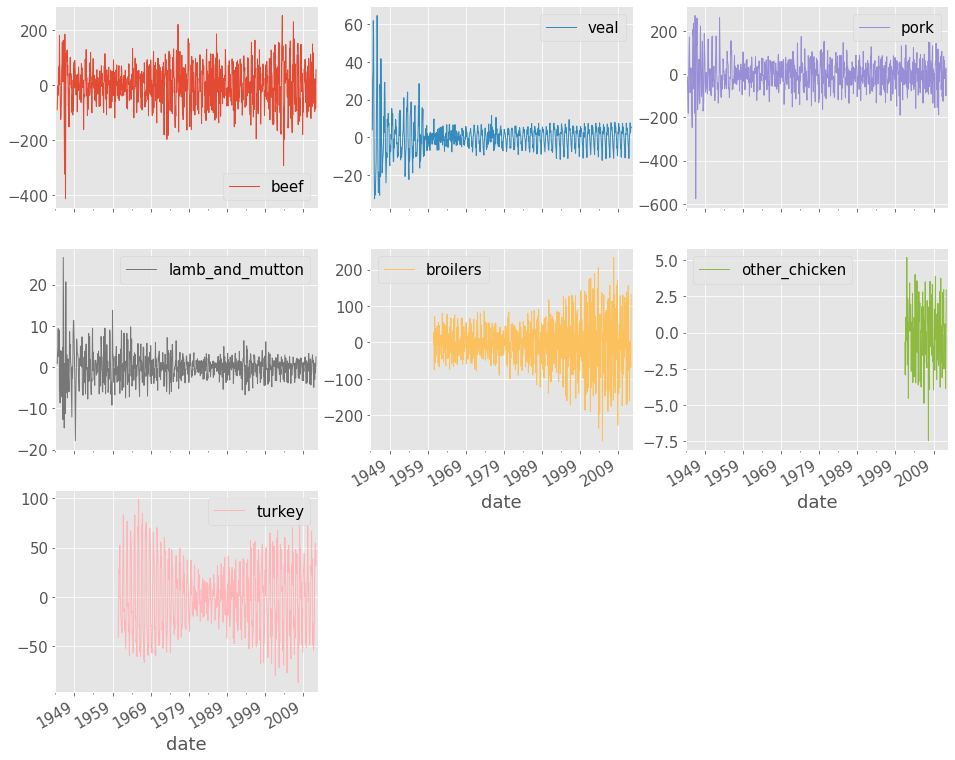

In [69]:
resid_dict = {}

for ts in meat.columns:
    decomposition = sm.tsa.seasonal_decompose(meat[ts].dropna())
    resid_dict[ts] = decomposition.resid

pd.DataFrame(resid_dict).plot(subplots=True, layout=(3, 3), linewidth=1);

> Calling `plot` on the whole `DecomposeResult` object will produce a plot with all components displayed on the same axes.

Decomposing your times series helps you think of them in a structured manner. Instead of imagining a series as a value changing over time, you can think of it as a distribution that has a particular seasonality signal or a feature with a particular slope. This level of data understanding can be a key factor during feature engineering and modeling.